# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

In [15]:
PATH_TO_DATA = 'D:/Projects/2022/dlcourse_ai-master/assignments/assignment2/data'

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [16]:
# First, lets load the dataset
data_train = dset.SVHN(PATH_TO_DATA, split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.SVHN(PATH_TO_DATA, split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [17]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [18]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [19]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [20]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    correct_samples = 0
    total_samples = 0

    for (x, y) in loader:
        prediction = model(x)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    accuracy = float(correct_samples) / total_samples

    return accuracy

In [21]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

In [22]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.821871, Train accuracy: 0.410248, Val accuracy: 0.550884
Average loss: 1.460724, Train accuracy: 0.580726, Val accuracy: 0.581394
Average loss: 1.380105, Train accuracy: 0.619561, Val accuracy: 0.614293


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [23]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.183154, Train accuracy: 0.201839, Val accuracy: 0.222306
Average loss: 1.998115, Train accuracy: 0.275450, Val accuracy: 0.317043
Average loss: 1.795443, Train accuracy: 0.381429, Val accuracy: 0.409870
Average loss: 1.700980, Train accuracy: 0.423609, Val accuracy: 0.434510
Average loss: 1.677401, Train accuracy: 0.436013, Val accuracy: 0.428844


Добавьте слой с Batch Normalization

In [24]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.913576, Train accuracy: 0.383203, Val accuracy: 0.540236
Average loss: 1.490726, Train accuracy: 0.594410, Val accuracy: 0.635588
Average loss: 1.322475, Train accuracy: 0.653380, Val accuracy: 0.668077
Average loss: 1.233168, Train accuracy: 0.676398, Val accuracy: 0.679612
Average loss: 1.177609, Train accuracy: 0.692506, Val accuracy: 0.703570


Добавьте уменьшение скорости обучения по ходу тренировки.

In [25]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, LR: %f" % (ave_loss,
                                                                                  train_accuracy,
                                                                                  val_accuracy,
                                                                                  step_lr.get_lr()[0]))

    return loss_history, train_history, val_history

In [26]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
step_lr = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, step_lr, 5)

d:\projects\2022\dlcourse_ai-master\assignments\assignment2\venv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
d:\projects\2022\dlcourse_ai-master\assignments\assignment2\venv\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Average loss: 1.964412, Train accuracy: 0.366874, Val accuracy: 0.537642, LR: 0.001000
Average loss: 1.564116, Train accuracy: 0.577603, Val accuracy: 0.611562, LR: 0.000250
Average loss: 1.437761, Train accuracy: 0.622172, Val accuracy: 0.644461, LR: 0.000500
Average loss: 1.357535, Train accuracy: 0.651230, Val accuracy: 0.665279, LR: 0.000125
Average loss: 1.315862, Train accuracy: 0.662884, Val accuracy: 0.673401, LR: 0.000250


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [27]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode

    # TODO: Evaluate model on the list of indices and capture predictions
    #       and ground truth labels
    # Hint: SubsetSampler above could be useful!
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
    predictions = []
    ground_truth = []

    for (x, y) in loader:
        prediction = model(x)
        predictions.extend(torch.argmax(prediction, 1).numpy())
        ground_truth.extend(y.numpy())

    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    return predictions, ground_truth

In [28]:
# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

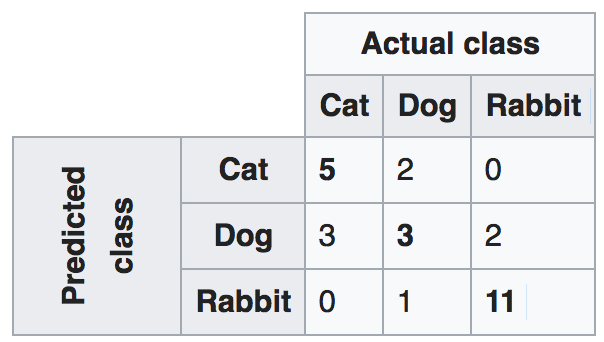

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [29]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    num_classes = len(np.unique(ground_truth))
    confusion_matrix = np.zeros((num_classes,num_classes), np.int)

    # TODO: Implement filling the prediction matrix
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = np.sum(predictions[ground_truth == j] == i)

    return confusion_matrix

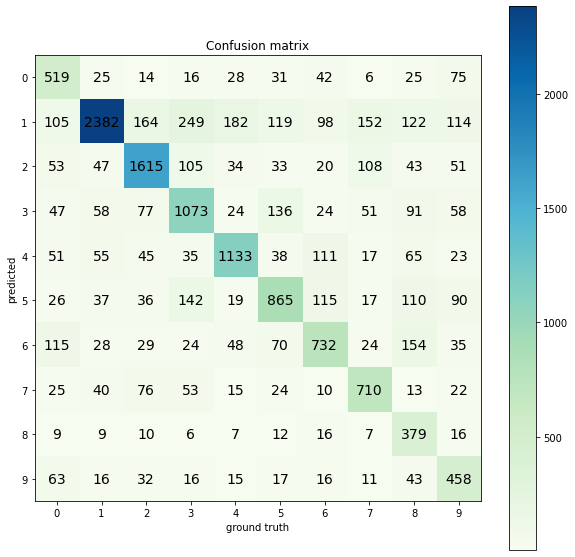

In [30]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [31]:
def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset

    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class

    predicted_class: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    title = 'Visualization: predicted_class is {0}, gt_class is {1}'.format(predicted_class, gt_class)
    indices_to_visualize = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices_to_visualize, data, title)

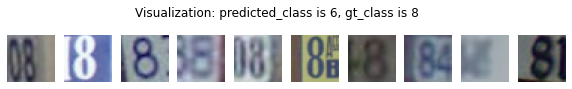

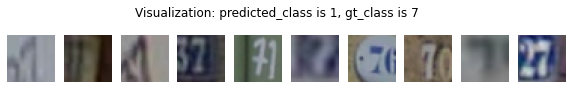

In [32]:
data_train_images = dset.SVHN(PATH_TO_DATA, split='train')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **60%**

In [33]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs, verbose=True):
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if verbose:
            print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, LR: %f" % (ave_loss,
                                                                                      train_accuracy,
                                                                                      val_accuracy,
                                                                                      step_lr.get_lr()[0]))
        else:
            if epoch % 5 == 0:
                print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss,
                                                                                  train_accuracy,
                                                                                  val_accuracy))

    return loss_history, train_history, val_history

In [34]:
from random import choice

n_iterations = 10
best_params = {}
best_model = None
best_loss_history = None
best_train_history = None
best_val_history = None

for i in range(n_iterations):
    print('Cycle: {0}'.format(i))

    nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

    params = {
        'lr': choice([1e-1, 1e-2, 1e-3]),
        'wd': choice([1e-1, 1e-2, 1e-3]),
        'momentum': choice([0.3, 0.5, 0.7, 0.9]),
        'eps': choice([1e-8, 1e-6, 1e-4, 1e-2, 1e-1]),
    }

    optims = {
        'sgd': optim.SGD(nn_model.parameters(), lr=params['lr'], weight_decay=params['wd']),
        'adam': optim.Adam(nn_model.parameters(), lr=params['lr'], weight_decay=params['wd'])
    }

    optimizer = optims[choice(list(optims.keys()))]

    schedulers = {
        'step_lr': optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5),
        'none': None
    }

    scheduler = schedulers[choice(list(schedulers.keys()))]
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader,
                                                           loss, optimizer, scheduler, n_iterations+1,
                                                           verbose=False)

    if best_val_history is None or val_history[-1] > best_val_history[-1]:
        best_params = params
        best_model = nn_model
        best_params['optimizer'] = optimizer
        best_params['schedulers'] = scheduler

        best_loss_history = loss_history
        best_train_history = train_history
        best_val_history = val_history

Cycle: 0
Average loss: 1.892281, Train accuracy: 0.387366, Val accuracy: 0.544195
Average loss: 0.931291, Train accuracy: 0.730079, Val accuracy: 0.732714
Average loss: 0.744353, Train accuracy: 0.776286, Val accuracy: 0.769982
Cycle: 1
Average loss: 1.877913, Train accuracy: 0.395489, Val accuracy: 0.546447
Average loss: 0.947015, Train accuracy: 0.724772, Val accuracy: 0.734762
Average loss: 0.755489, Train accuracy: 0.774545, Val accuracy: 0.778036
Cycle: 2
Average loss: 1.876054, Train accuracy: 0.403798, Val accuracy: 0.567675
Average loss: 0.941199, Train accuracy: 0.727229, Val accuracy: 0.725002
Average loss: 0.762184, Train accuracy: 0.772702, Val accuracy: 0.774282
Cycle: 3
Average loss: 2.291337, Train accuracy: 0.171262, Val accuracy: 0.148386
Average loss: 2.329984, Train accuracy: 0.157441, Val accuracy: 0.151116
Average loss: 2.317274, Train accuracy: 0.159489, Val accuracy: 0.151730
Cycle: 4
Average loss: 1.370352, Train accuracy: 0.554534, Val accuracy: 0.624053
Averag

In [35]:
print("Best model")
print("Params:", best_params)
print()
print("Loss: %f, Train accuracy: %f, Val accuracy: %f" % (best_loss_history[-1],
                                                          best_train_history[-1],
                                                          best_val_history[-1]))

Best model
Params: {'lr': 0.001, 'wd': 0.01, 'momentum': 0.3, 'eps': 1e-08, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 3.125e-05
    maximize: False
    weight_decay: 0.01
), 'schedulers': <torch.optim.lr_scheduler.StepLR object at 0x0000029A9EE1EA00>}

Loss: 0.678736, Train accuracy: 0.799747, Val accuracy: 0.807795


In [36]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.6201
